In [7]:
# Deepfake Detection with XceptionNet Data Loading
# Uses ImageDataGenerator for images and custom generator for videos
# --------------------------------------------------------------

# Imports
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [8]:

# --------------------------------------------------------------
#  Parameters
DATA_DIR = 'Dataset'
IMG_DIR = os.path.join(DATA_DIR, 'Images')

IMG_SIZE = (299, 299)
BATCH_SIZE_IMG = 16
EPOCHS_IMG = 10

# --------------------------------------------------------------
# IMAGE DATA GENERATOR (memory-efficient)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    IMG_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE_IMG,
    subset='training',
    class_mode='binary'
)

val_gen = train_datagen.flow_from_directory(
    IMG_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE_IMG,
    subset='validation',
    class_mode='binary'
)


Found 8008 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [ ]:

# --------------------------------------------------------------
# Xception Image Model
base_cnn = Xception(include_top=False, input_shape=(299, 299, 3), pooling='avg', weights='imagenet')
base_cnn.trainable = False

model_img = models.Sequential([
    base_cnn,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

model_img.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_img = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint('saved_models/best_image_model_xception.h5', save_best_only=True)
]

# --------------------------------------------------------------
#  Train Image Model
print("\nTraining Xception Image Model...")
history_img = model_img.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_IMG,
    callbacks=callbacks_img,
    verbose=1
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

Training Xception Image Model...
Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6655 - loss: 0.6089

501/501 ━━━━━━━━━━━━━━━━━━━━ 1191s 2s/step - accuracy: 0.7030 - loss: 0.5701 - val_accuracy: 0.7752 - val_loss: 0.4476
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7445 - loss: 0.5162

501/501 ━━━━━━━━━━━━━━━━━━━━ 1357s 3s/step - accuracy: 0.7428 - loss: 0.5118 - val_accuracy: 0.8511 - val_loss: 0.3627
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7604 - loss: 0.4896

501/501 ━━━━━━━━━━━━━━━━━━━━ 1178s 2s/step - accuracy: 0.7581 - loss: 0.4883 - val_accuracy: 0.8551 - val_loss: 0.3540
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 1114s 2s/step - accuracy: 0.7721 - loss: 0.4735 - val_accuracy: 0.8192 - val_loss: 0.3786
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 1209s 2s/step - accuracy: 0.7881 - loss: 0.4509 - val_accuracy: 0.8302 - val_loss: 0.3588
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 1112s 2s/step - accuracy: 0.7970 - loss: 0.4330 - val_accuracy: 0.8382 - val_loss: 0.3665


In [ ]:

# Fine-tune
print("\nFine-tuning Image Model...")
base_cnn.trainable = True
for layer in base_cnn.layers[:-50]:
    layer.trainable = False

model_img.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_img.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks_img,
    verbose=1
)

model_img.save('saved_models/final_image_deepfake_model_xception.h5')





Fine-tuning Image Model...
Epoch 1/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7606 - loss: 0.4772

501/501 ━━━━━━━━━━━━━━━━━━━━ 2024s 4s/step - accuracy: 0.8009 - loss: 0.4237 - val_accuracy: 0.9121 - val_loss: 0.2039
Epoch 2/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8879 - loss: 0.2785

501/501 ━━━━━━━━━━━━━━━━━━━━ 1993s 4s/step - accuracy: 0.8995 - loss: 0.2553 - val_accuracy: 0.9311 - val_loss: 0.1664
Epoch 3/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9363 - loss: 0.1736

501/501 ━━━━━━━━━━━━━━━━━━━━ 2049s 4s/step - accuracy: 0.9364 - loss: 0.1649 - val_accuracy: 0.9456 - val_loss: 0.1313
Epoch 4/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 2322s 5s/step - accuracy: 0.9563 - loss: 0.1158 - val_accuracy: 0.9426 - val_loss: 0.1393
Epoch 5/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9727 - loss: 0.0768

501/501 ━━━━━━━━━━━━━━━━━━━━ 1979s 4s/step - accuracy: 0.9730 - loss: 0.0760 - val_accuracy: 0.9575 - val_loss: 0.1126



Evaluating image model...


Evaluating batches:   0%|          | 0/126 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:   1%|          | 1/126 [00:02<04:41,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating batches:   2%|▏         | 2/126 [00:03<03:29,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating batches:   2%|▏         | 3/126 [00:04<03:06,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating batches:   3%|▎         | 4/126 [00:06<02:52,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating batches:   4%|▍         | 5/126 [00:07<02:44,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating batches:   5%|▍         | 6/126 [00:08<02:42,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:   6%|▌         | 7/126 [00:10<02:57,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:   6%|▋         | 8/126 [00:12<03:14,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:   7%|▋         | 9/126 [00:14<03:27,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:   8%|▊         | 10/126 [00:16<03:39,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:   9%|▊         | 11/126 [00:19<04:02,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  10%|▉         | 12/126 [00:22<04:29,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  10%|█         | 13/126 [00:24<04:38,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  11%|█         | 14/126 [00:27<04:54,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  12%|█▏        | 15/126 [00:30<05:00,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  13%|█▎        | 16/126 [00:33<04:57,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  13%|█▎        | 17/126 [00:35<04:42,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  14%|█▍        | 18/126 [00:38<04:25,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  15%|█▌        | 19/126 [00:40<04:14,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  16%|█▌        | 20/126 [00:42<04:02,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  17%|█▋        | 21/126 [00:44<03:56,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  17%|█▋        | 22/126 [00:46<03:56,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  18%|█▊        | 23/126 [00:48<03:46,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  19%|█▉        | 24/126 [00:50<03:36,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  20%|█▉        | 25/126 [00:52<03:27,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  21%|██        | 26/126 [00:54<03:20,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  21%|██▏       | 27/126 [00:56<03:15,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  22%|██▏       | 28/126 [00:58<03:12,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  23%|██▎       | 29/126 [01:00<03:18,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  24%|██▍       | 30/126 [01:03<03:32,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  25%|██▍       | 31/126 [01:05<03:29,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  25%|██▌       | 32/126 [01:08<03:39,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  26%|██▌       | 33/126 [01:10<03:34,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  27%|██▋       | 34/126 [01:12<03:31,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  28%|██▊       | 35/126 [01:15<03:36,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  29%|██▊       | 36/126 [01:17<03:36,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  29%|██▉       | 37/126 [01:20<03:42,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  30%|███       | 38/126 [01:22<03:27,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  31%|███       | 39/126 [01:24<03:13,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  32%|███▏      | 40/126 [01:26<03:04,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  33%|███▎      | 41/126 [01:28<02:57,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  33%|███▎      | 42/126 [01:30<03:05,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  34%|███▍      | 43/126 [01:33<03:19,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  35%|███▍      | 44/126 [01:36<03:30,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Evaluating batches:  36%|███▌      | 45/126 [01:39<03:47,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  37%|███▋      | 46/126 [01:42<03:40,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  37%|███▋      | 47/126 [01:45<03:36,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  38%|███▊      | 48/126 [01:47<03:29,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  39%|███▉      | 49/126 [01:50<03:27,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  40%|███▉      | 50/126 [01:52<03:19,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  40%|████      | 51/126 [01:54<03:03,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  41%|████▏     | 52/126 [01:57<02:52,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  42%|████▏     | 53/126 [01:58<02:42,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  43%|████▎     | 54/126 [02:00<02:35,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  44%|████▎     | 55/126 [02:02<02:29,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  44%|████▍     | 56/126 [02:05<02:26,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  45%|████▌     | 57/126 [02:07<02:34,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  46%|████▌     | 58/126 [02:09<02:34,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  47%|████▋     | 59/126 [02:12<02:31,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  48%|████▊     | 60/126 [02:14<02:26,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  48%|████▊     | 61/126 [02:16<02:26,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  49%|████▉     | 62/126 [02:19<02:31,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  50%|█████     | 63/126 [02:21<02:29,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  51%|█████     | 64/126 [02:24<02:28,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  52%|█████▏    | 65/126 [02:26<02:21,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  52%|█████▏    | 66/126 [02:28<02:12,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  53%|█████▎    | 67/126 [02:30<02:04,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  54%|█████▍    | 68/126 [02:32<01:59,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  55%|█████▍    | 69/126 [02:34<01:56,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  56%|█████▌    | 70/126 [02:36<01:53,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  56%|█████▋    | 71/126 [02:38<01:50,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  57%|█████▋    | 72/126 [02:39<01:45,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  58%|█████▊    | 73/126 [02:41<01:41,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  59%|█████▊    | 74/126 [02:43<01:38,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  60%|█████▉    | 75/126 [02:45<01:35,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  60%|██████    | 76/126 [02:47<01:32,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  61%|██████    | 77/126 [02:49<01:30,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  62%|██████▏   | 78/126 [02:50<01:29,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  63%|██████▎   | 79/126 [02:52<01:28,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  63%|██████▎   | 80/126 [02:54<01:29,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  64%|██████▍   | 81/126 [02:56<01:27,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  65%|██████▌   | 82/126 [02:58<01:25,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  66%|██████▌   | 83/126 [03:00<01:25,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  67%|██████▋   | 84/126 [03:03<01:25,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  67%|██████▋   | 85/126 [03:05<01:30,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  68%|██████▊   | 86/126 [03:08<01:31,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  69%|██████▉   | 87/126 [03:10<01:29,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  70%|██████▉   | 88/126 [03:12<01:23,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  71%|███████   | 89/126 [03:14<01:19,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  71%|███████▏  | 90/126 [03:16<01:18,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  72%|███████▏  | 91/126 [03:18<01:17,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  73%|███████▎  | 92/126 [03:20<01:11,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  74%|███████▍  | 93/126 [03:22<01:06,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  75%|███████▍  | 94/126 [03:24<01:02,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  75%|███████▌  | 95/126 [03:26<01:00,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  76%|███████▌  | 96/126 [03:28<00:57,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  77%|███████▋  | 97/126 [03:30<00:54,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  78%|███████▊  | 98/126 [03:32<00:53,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  79%|███████▊  | 99/126 [03:33<00:51,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  79%|███████▉  | 100/126 [03:35<00:48,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  80%|████████  | 101/126 [03:37<00:46,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  81%|████████  | 102/126 [03:39<00:44,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  82%|████████▏ | 103/126 [03:41<00:42,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  83%|████████▎ | 104/126 [03:43<00:40,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  83%|████████▎ | 105/126 [03:44<00:38,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  84%|████████▍ | 106/126 [03:46<00:36,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  85%|████████▍ | 107/126 [03:48<00:34,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  86%|████████▌ | 108/126 [03:50<00:32,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  87%|████████▋ | 109/126 [03:52<00:31,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  87%|████████▋ | 110/126 [03:54<00:30,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  88%|████████▊ | 111/126 [03:56<00:29,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  89%|████████▉ | 112/126 [03:58<00:28,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  90%|████████▉ | 113/126 [04:00<00:25,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  90%|█████████ | 114/126 [04:02<00:23,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  91%|█████████▏| 115/126 [04:04<00:22,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  92%|█████████▏| 116/126 [04:06<00:20,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  93%|█████████▎| 117/126 [04:08<00:18,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  94%|█████████▎| 118/126 [04:10<00:16,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  94%|█████████▍| 119/126 [04:12<00:14,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  95%|█████████▌| 120/126 [04:14<00:12,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  96%|█████████▌| 121/126 [04:16<00:09,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  97%|█████████▋| 122/126 [04:18<00:07,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  98%|█████████▊| 123/126 [04:20<00:05,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  98%|█████████▊| 124/126 [04:22<00:03,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Evaluating batches:  99%|█████████▉| 125/126 [04:24<00:01,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating batches: 100%|██████████| 126/126 [04:25<00:00,  2.10s/it]


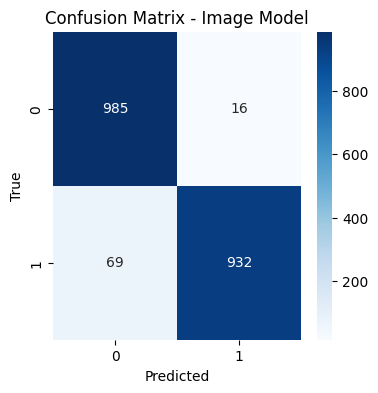


Classification Report (Image Model):
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1001
         1.0       0.98      0.93      0.96      1001

    accuracy                           0.96      2002
   macro avg       0.96      0.96      0.96      2002
weighted avg       0.96      0.96      0.96      2002



In [ ]:
# Evaluate the model
def evaluate_image_model(model, generator):
    y_true, y_pred = [], []
    # Iterate through the generator using indexing
    for i in tqdm(range(len(generator)), desc="Evaluating batches"):
        X_batch, y_batch = generator[i]
        preds = (model.predict(X_batch) > 0.5).astype(int)
        y_true.extend(y_batch)
        y_pred.extend(preds.flatten())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Image Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("\nClassification Report (Image Model):")
    print(classification_report(y_true, y_pred))

print("\nEvaluating image model...")
evaluate_image_model(model_img, val_gen)

In [3]:
# =====================================================
#  Deepfake Detection - Single Image Prediction Script
# Model: Xception (trained on real/fake image dataset)
# =====================================================

from tensorflow.keras.models import load_model

# ========== PARAMETERS ==========
MODEL_PATH = "saved_models/final_image_deepfake_model_xception.h5"  # or final_image_deepfake_model.h5
# MODEL_PATH = "saved_models/best_image_model_xception.h5" 
IMG_SIZE = (299, 299)

# ========== LOAD MODEL ==========
print(" Loading model...")
model = load_model(MODEL_PATH, compile=False)
print(" Model loaded successfully.")

# ========== HELPER FUNCTION ==========
def preprocess_image(image_path):
    """Read and preprocess the image for Xception model."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return np.expand_dims(img, axis=0)

def predict_image(model, image_path):
    """Predict Real/Fake for given image."""
    img_tensor = preprocess_image(image_path)
    pred = model.predict(img_tensor)[0][0]

    label = "Real" if pred > 0.5 else "Fake"
    confidence = pred if label == "Real" else 1 - pred

    print(f"\n Image: {image_path}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence * 100:.2f}%")


image_path = "Dataset/nitin_pic.jpg"
predict_image(model, image_path)

 Loading model...
 Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step

 Image: Dataset/nitin_pic.jpg
Prediction: Real
Confidence: 99.84%


In [35]:
print(train_gen.class_indices)


{'fake': 0, 'real': 1}


In [45]:
print("Model output shape:", model.output_shape)
print("Model Summary",model.summary())


Model output shape: (None, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 12,693,105 (48.42 MB)

 Non-trainable params: 8,693,176 (33.16 MB)

Model Summary None
